# fitting annihilation msr timeseries to the affine oscillatory particle model
Tim Tyree<br>
7.5.2022

In [1]:
from IPython.display import clear_output
clear_output(wait=True)

import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *

os.chdir(nb_dir)
from lib import *

# import cupy, cudf
# from lib.rapids_func import *

import seaborn as sns
import matplotlib.ticker as mtick

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

In [2]:
# from scipy.optimize import minimize
from scipy.optimize import dual_annealing

In [3]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

In [4]:
#TODO: copy to lib.model
def comp_square_error_msr_aff_osc(x,*args):
    """phase is in radians. period is in milliseconds.  a0,a1 are in cm^2/s.

Example Usage:
x0=a0,a1,period,phase
args=t_values,msr_values,D
square_error=comp_square_error_msr_aff_osc(x0,*args)
rmse=np.sqrt(square_error/t_values.shape[0])
print(f"{rmse=}")
    """
    a0,a1,period,phase=x
    t_values,msr_values,D=args
    omega=2*np.pi/period*1e3 #Hz bc period is in ms
    msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
    square_error_msr=np.sum((msr_values_affoscillatory-msr_values)**2)
    return square_error_msr

def anneal_msr_fit(t_values,msr_values,D,
                   bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
                   maxiter=1000,
                   seed=42,
                   no_local_search=True,
                   **kwargs):
    """returns fit of MSR(t') to the affine oscillatory particle model.
    if no_local_search=True, simulated annealing is used.
    if no_local_search=False, dual annealing is used.
    kwargs are passed to scipy.optimize.dual_annealing
    bounds gives the upper/lower bounds to parameter values a0 (cm^2/s), a1 (cm^2/s), period (ms), and phase (radians), respectively.

    Example Usage:
res = anneal_msr_fit(t_values,msr_values,D,
                   bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
                   maxiter=1000,seed=42, no_local_search=True)#,**kwargs)
    """
    # input: t_values, msr_values, D, Gamma
    # output: a0,a1,period,phase,rmse,alinear
    args=t_values,msr_values,D
    # np.random.seed(42)   # seed to allow replication.
    res = dual_annealing(
        comp_square_error_msr_aff_osc,
        bounds=bounds,
        args=args,
        maxiter=maxiter,
        seed=seed,
        no_local_search=no_local_search,**kwargs)
    return res

def comp_alinear(a0,a1,period,Gamma,phase):
    """computes the effective attraction coefficient of the linear particle model.
    a0,a1 are in units of alinear. 
    period is in units of the mean minimum lifetime, Gamma. 
    phase is in units of radians.
    
    Example Usage:
alinear = comp_alinear(a0,a1,period,Gamma,phase)
    """
    omega = 2*np.pi/period
    z = Gamma*omega
    alinear=a0 + a1*(np.cos(phase)-z*np.sin(phase))/(1 + z**2)
    return alinear

In [5]:
def comp_mean_bootstrap_uncertainty(x,num_samples=1000):
    """
    Example Usage:
meanx,Delta_meanx,num_obs,p_normal=comp_mean_bootstrap_uncertainty(minlifetime_values)
printing=True
if printing:
    print(f"mean: {meanx:.4f} +/- {Delta_meanx:.4f} (N={num_obs}, {p_normal=:.4f})")
    """
    meanx = np.mean(x)
    Delta_meanx,p_normal=bootstrap_95CI_Delta_mean(x,num_samples=num_samples)
    num_obs=x.shape[0]
    return meanx,Delta_meanx,num_obs,p_normal

# load data

In [5]:
#load spiral tip range time series from cache
#######################
# Luo-Rudy
#######################
#WJ's data for LR model (200x200)
range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_annihilation_range_timeseries.pkl'
# #my data for LR model (200x200) diffCoeff=0.001
range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_range_timeseries.pkl'
#my data for LR model (200x200) diffCoeff=0.0005
range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilation_range_timeseries.pkl'

#######################
# Fenton-Karma
#######################

# range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilation_range_timeseries.pkl'
range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_1/annihilation_range_timeseries.pkl'
# range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilation_range_timeseries.pkl'
# range_data_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/annihilation_range_timeseries.pkl'



data_lst=load_from_pickle(range_data_dir)
print(f"loaded range timeseries from {len(data_lst)} termination events")
df=pd.concat(data_lst)
del data_lst
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_1/annihilation_range_timeseries.pkl'

# compute mean minimum lifetime

In [ ]:
bins=80
color='C1'
# color='C0'
# bins=np.logspace(-2,2,100)
minlifetime_values = df.groupby(by=['trial_num','annihilation_index'])['tdeath'].max().values
plt.hist(minlifetime_values,bins=bins,density=True,log=True,color=color,alpha=0.7)
format_plot(ax=plt.gca(),xlabel=r'min$(\Gamma_1,\Gamma_2)$ (ms)',ylabel='PDF')
plt.show()

In [ ]:
meanx,Delta_meanx,num_obs,p_normal=comp_mean_bootstrap_uncertainty(minlifetime_values)
printing=True
if printing:
    print(f"mean lifetime: {meanx:.4f} +/- {Delta_meanx:.4f} ms (N={num_obs}, {p_normal=:.4f})")

# Compute MSR(t') by averaging range timeseries

In [27]:
x_values_in=df['tdeath'].values
y_values_in=df['R'].values**2
print(f"tdeath ranges from {np.min(x_values_in)} to {np.max(x_values_in)} ms")
print(f"R^2 ranges from {np.min(y_values_in)} to {np.max(y_values_in)} cm^2")

KeyError: 'tdeath'

In [59]:
assert not np.isnan(x_values_in).any() 
assert not np.isnan(y_values_in).any()

In [60]:
#compute bootstrap 
# bins=np.arange(0,450,1)
# bins=np.arange(0,1800,5)
bins=np.arange(0,2800,5)
df_bootstrap=bin_and_bootstrap_xy_values_parallel(x_values_in,
                               y_values_in,
                               xlabel='tdeath_avg',
                               ylabel='MSR',
                               bins=bins,
                               min_numobs=10,
                               num_bootstrap_samples=1000,
                               npartitions=10,
                               use_test=False)
df_bootstrap.head()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
0,2.302685,0.101907,0.017385,0.001099,0.596408,0.020035,37914
1,7.977174,0.215369,0.015636,0.002290,0.062441,0.917820,25445
2,12.780152,0.273737,0.016777,0.002968,0.961914,0.013977,24022
3,17.580277,0.324734,0.016321,0.003689,0.360833,0.293810,22715
4,22.377199,0.371408,0.018235,0.004455,0.473704,0.636188,21403


In [61]:
df_bootstrap.tail()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
311,1556.800000,3.774760,0.747381,0.649430,0.604701,0.801924,12
312,1562.215385,3.781276,0.994753,0.650068,0.587286,0.005006,13
313,1602.400000,5.233339,1.001279,0.206936,0.330677,0.824348,12
314,1642.400000,5.249468,0.981707,0.954804,0.603401,0.644642,12
315,1682.400000,5.076051,1.023012,0.878101,0.143062,0.027473,12


In [62]:
x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
yerr_values=df_bootstrap['Delta_MSR'].values
x_values.shape,y_values.shape,yerr_values.shape

((316,), (316,), (316,))

Does this appear to intersect at zero?


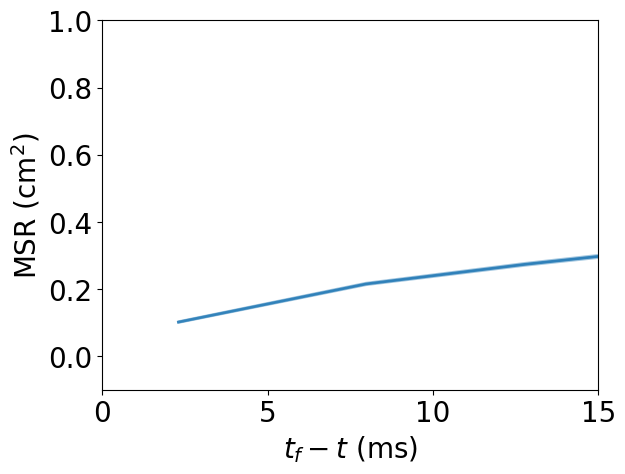

In [63]:
print(f"Does this appear to intersect at zero?")
c='C0'
plt.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
plt.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
# plt.xlim([0,180])
# plt.ylim([0,3.1])
plt.xlim([0,15])
plt.ylim([-.1,1])
plt.show()

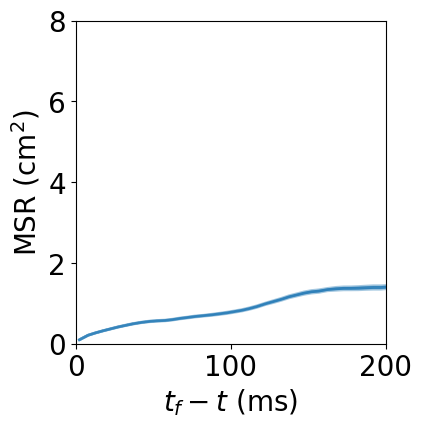

In [64]:
#plot expected
fig,ax=plt.subplots(figsize=(4,4.2))
# ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
ax.set_xlim([0,200])
ax.set_ylim([0,8])
plt.show()

In [65]:
# range_data_dir

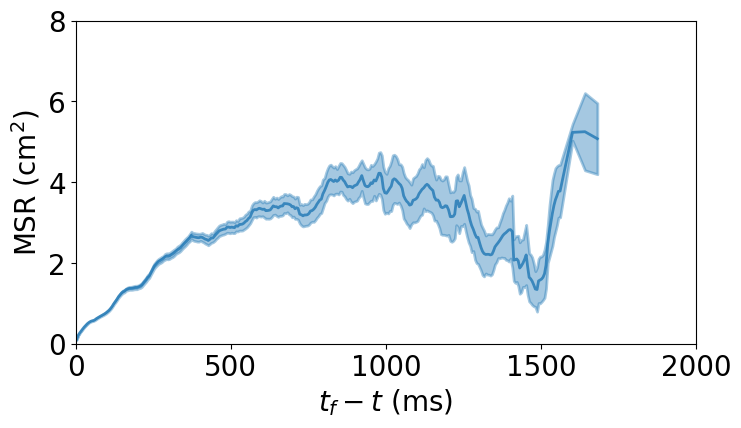

In [66]:
#plot expected
fig,ax=plt.subplots(figsize=(8,4.2))
# ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
ax.set_xlim([0,2000])
ax.set_ylim([0,8])
plt.show()

In [67]:
#save msr as .csv
msr_dir_bootstrap=range_data_dir.replace('annihilation_range_timeseries.pkl','annihilation_msr.csv')
df_bootstrap.to_csv(msr_dir_bootstrap,index=False)
print(f"{msr_dir_bootstrap=}")

msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilation_msr.csv'


In [5]:
# search_for_file()

In [52]:
# input_dir='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.1_log.csv'
# input_folder=os.path.dirname(input_dir)
# fn_lst=[os.path.join(input_folder,x) for x in sorted(os.listdir(input_folder)) if x.find('_log.csv')!=-1]
# print(f"found {len(fn_lst)} files comparable to {fn_lst[0]}")


found 324 files comparable to /home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/Log/ic200x200.0.0_log.csv


# MSR-Consistent Theory

Our hypothesis is that the range between particles is consistent between the two particle models in the mean square.  In other words,
$$
\mathbb{E}_{\Gamma/2}\Big[\text{MSR}_\text{Lin.}\Big] \overset{!}{=} \mathbb{E}_{\Gamma/2}\Big[\text{MSR}_\text{Aff.Osc}\Big].
$$

Let $z=\omega(\Gamma/2)$, $D_\text{Aff.Osc.}=D_\text{Lin.}=D=$constant, and let $\phi_f=0$. Then, the aforementioned _ansatz_ simplifies to

$$
a_\text{Lin.}=a_0 + \frac{a_1}{1+z^2}.
$$


For general $\phi_f\in\mathbb{R}$, the aforementioned _ansatz_ simplifies to

$$
a_\text{Lin.}=a_0 + a_1\frac{\cos(\phi_f)-z\sin(\phi_f)}{1+z^2}.
$$

In [5]:
#WJ'S informal fit from fortran
#predicted values
a0=5.4958675607488825 #cm^2/s
a1=6.2229999145162314 #cm^2/s
period=179.51957944083097 #ms
# phase=1.1497012691466562
# phase=0
phase=-1.1497012691466562
Gamma = 20 #ms


omega = 2*np.pi/period
z = Gamma*omega
alinear=a0 + a1*(np.cos(phase)-z*np.sin(phase))/(1 + z**2)
print(f"{a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f}")

a0=5.4959, a1=6.2230, z=0.7000, phase=-1.1497 --> alinear=9.8712


# Fit MSR(t') to the affine oscillatory model

## load MSR(t') data

In [6]:
# #######################
# # Luo-Rudy
# #######################
# #WJ's data for LR model (200x200)
# # msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_annihilation_msr.csv'
# # #my data for LR model (200x200) diffCoeff=0.001
# # msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_msr.csv'
# # #my data for LR model (200x200) diffCoeff=0.0005
# # msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilation_msr.csv'

# #######################
# # Fenton-Karma
# #######################
# # msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilation_msr.csv'
# msr_dir_bootstrap='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_1/annihilation_msr.csv'

In [6]:
# #######################
# # Luo-Rudy
# #######################
# #WJ's data for LR model (200x200)
msr_dir_bootstrap=f'{nb_dir}/Data/range_timeseries/from_wjr_lr_200x200_diffcoeff_0.001/tippos_per_001_annihilation_msr.csv'
# # # #my data for LR model (200x200) diffCoeff=0.001
# msr_dir_bootstrap=f'{nb_dir}/Data/range_timeseries/initial-conditions-suite-3-LR_ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001/annihilation_msr.csv'
# # # #my data for LR model (200x200) diffCoeff=0.0005
# msr_dir_bootstrap=f'{nb_dir}/Data/range_timeseries/initial-condition-suite-3-LR_param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilation_msr.csv'

# # #######################
# # # Fenton-Karma
# # #######################
# msr_dir_bootstrap=f'{nb_dir}/Data/range_timeseries/initial-conditions-fk-200x200_param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilation_msr.csv'
# msr_dir_bootstrap=f'{nb_dir}/Data/range_timeseries/initial-conditions-fk-200x200_param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_1/annihilation_msr.csv'

# save_folder=f'{nb_dir}/Data/range_timeseries/'


In [7]:
df_bootstrap=pd.read_csv(msr_dir_bootstrap)
df_bootstrap.head()

,tdeath_avg,MSR,Delta_tdeath_avg,Delta_MSR,p_tdeath_avg,p_MSR,counts
0,0.0,0.039163,0.0,0.000592,0.0,0.591300,15273
1,1.0,0.112644,0.0,0.001484,0.0,0.829643,13885
2,2.0,0.173819,0.0,0.002409,0.0,0.894476,13043
3,3.0,0.229284,0.0,0.003359,0.0,0.123128,12294
4,4.0,0.282268,0.0,0.004175,0.0,0.842903,11661


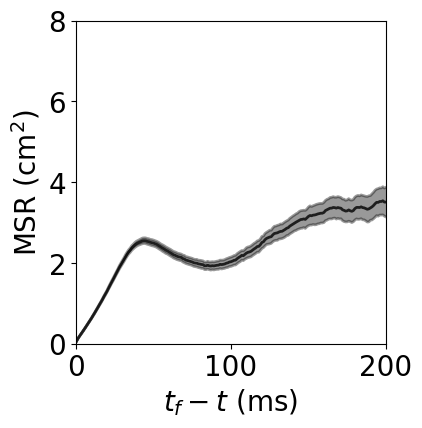

In [8]:
#plot expected
# c='C0'
c='C1'
c='k'
# figsize=(8,4.2)
figsize=(4,4.2)

x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
yerr_values=df_bootstrap['Delta_MSR'].values
x_values.shape,y_values.shape,yerr_values.shape

fig,ax=plt.subplots(figsize=figsize)
# ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c)
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
ax.set_xlim([0,200])
# ax.set_xlim([0,2000])
ax.set_ylim([0,8])
plt.show()

## fit the full msr to the affine oscillatory msr using simulated annealing

In [9]:
#select msr from the full models for fitting
# max_tdeath=100. #ms
# max_tdeath=200. #ms
max_tdeath=300. #ms
#INPUT: FK MODEL
boo=x_values<max_tdeath
t_values=x_values[boo].copy()*1e-3
msr_values=y_values[boo].copy() 
msr_values-= np.min(msr_values)
D=0.365 #cm^2/s, as observed
Gamma = 100. # ~ 197/2 #ms #for predicting alinear only
# Gamma = 200. # ~ 197/2 #ms #for predicting alinear only

# #INPUT: LR MODEL
max_tdeath=100. #ms
boo=x_values<max_tdeath
t_values=x_values[boo].copy()*1e-3
msr_values=y_values[boo].copy()
msr_values-= np.min(msr_values)
D=0.58 #cm^2/s, as observed
Gamma = 33.4 # 20. # ~ 40/2 #ms #for predicting alinear only

print(f"{max_tdeath=} ms")
print(f"src: {msr_dir_bootstrap=}")

max_tdeath=100.0 ms
src: msr_dir_bootstrap='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/range_timeseries/from_wjr_lr_200x200_diffcoeff_0.001/tippos_per_001_annihilation_msr.csv'


In [10]:
maxiter=10000
print(f"num. epochs: {maxiter}")
res = anneal_msr_fit(t_values,msr_values,D,
                   bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
                   maxiter=maxiter,seed=42, no_local_search=True)#,**kwargs)
rmse= np.sqrt(res.fun/t_values.shape[0])
a0,a1,period,phase=res.x
print(f"simulated annealing fit: {a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f} --> {rmse=:.4f} cm^2")

alinear = comp_alinear(a0,a1,period,Gamma,phase)
omega = 2*np.pi/period
z = Gamma*omega
print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")

maxiter=100000
print(f"num. epochs: {maxiter}")
res = anneal_msr_fit(t_values,msr_values,D,
                   bounds = ((0, 100), (0, 100), (50, 300), (-3.15,3.15)),
                   maxiter=maxiter,seed=42+1, no_local_search=True)#,**kwargs)
rmse= np.sqrt(res.fun/t_values.shape[0])
a0,a1,period,phase=res.x
print(f"simulated annealing fit: {a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f} --> {rmse=:.4f} cm^2")

alinear = comp_alinear(a0,a1,period,Gamma,phase)
omega = 2*np.pi/period
z = Gamma*omega
print(f"\tattraction coefficient: {a0=:.4f}, {a1=:.4f}, {z=:.4f}, {phase=:.4f} --> {alinear=:.4f} cm^2/s")

num. epochs: 10000
simulated annealing fit: a0=4.4730, a1=12.2940, period=104.4021, phase=-0.8972 --> rmse=0.0595 cm^2
	attraction coefficient: a0=4.4730, a1=12.2940, z=2.0101, phase=-0.8972 --> alinear=9.8263 cm^2/s
num. epochs: 100000
simulated annealing fit: a0=4.3874, a1=12.4863, period=102.1579, phase=-0.9685 --> rmse=0.0590 cm^2
	attraction coefficient: a0=4.3874, a1=12.4863, z=2.0543, phase=-0.9685 --> alinear=9.7918 cm^2/s


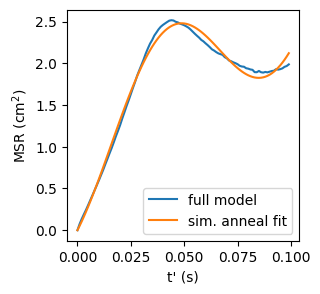

In [11]:
#visualize the fit zoomed
boo=x_values<max_tdeath
t_values=x_values[boo].copy()*1e-3

figsize=(3,3)
fontsize=10
fig,ax=plt.subplots(figsize=figsize)
period_of_oscillation=period*1e-3 #seconds
omega=2*np.pi/period_of_oscillation
msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
plt.plot(t_values,msr_values,label='full model')
plt.plot(t_values,msr_values_affoscillatory,label='sim. anneal fit')
# plt.plot(t_values,msr_values_affoscillatory,label='fit to full')
format_plot(ax=plt.gca(),xlabel=r"t' (s)",ylabel=r"MSR (cm$^2$)",fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

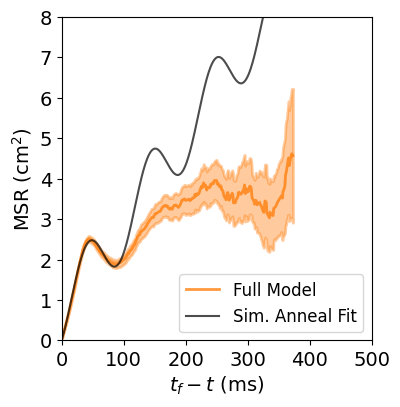

In [12]:
#plot expected
# c='C0'
c='C1'
# figsize=(8,4.2)
figsize=(4,4.2)
fontsize=14

x_values=df_bootstrap['tdeath_avg'].values
y_values=df_bootstrap['MSR'].values
y_values-=np.min(y_values)
yerr_values=df_bootstrap['Delta_MSR'].values

t_values=x_values*1e-3
msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))



fig,ax=plt.subplots(figsize=figsize)
# ax.plot(x_values,4*9.5*1e-3*x_values,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(x_values,4*1.8*1e-3*x_values,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values,y_values,lw=2,alpha=0.8,c=c, label='Full Model')
ax.fill_between(x_values,y_values-yerr_values,y_values+yerr_values,lw=2,alpha=0.4,color=c)

ax.plot(t_values*1e3,msr_values_affoscillatory,label='Sim. Anneal Fit',c='k',alpha=0.7)

format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
ax.set_xlim([0,500])
# ax.set_xlim([0,2000])
ax.set_ylim([0,8])
plt.legend(fontsize=fontsize-2)

plt.show()

# (supplementary) fit MSR(t') using fancy, complicated methods

In [590]:
from scipy.optimize import minimize
def comp_square_error_msr_period_fixed(x,*args):
    """phase is in radians. period is in milliseconds.  a0,a1 are in cm^2/s.

Example Usage:
x0=a0,a1,phase
args=t_values,msr_values,D,period
square_error=comp_square_error_msr_aff_osc(x0,*args)
rmse=np.sqrt(square_error/t_values.shape[0])
print(f"{rmse=}")
    """
    a0,a1,phase=x
    t_values,msr_values,D,period=args
    omega=2*np.pi/period*1e3 #Hz bc period is in ms
    msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
    square_error_msr=np.sum((msr_values_affoscillatory-msr_values)**2)
    return square_error_msr

m=14.413057752177012
b=1.0696028305996794
Rsquared=0.38314383286833603


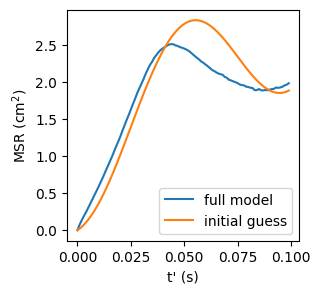

rmse=0.2967137861796891
baseline loss: rmse=0.2967 cm^2 (from a0=3.6033, a1=14.4131, period=100.0000, phase=-1.5708)
method='Nelder-Mead': a0_=4.3331, a1_=12.6700, period_=104.4021, phase_=-1.0350, rmse=0.06022575035499659
method='Powell': a0_=4.3330, a1_=12.6699, period_=104.4021, phase_=-1.0350, rmse=0.06022574586310302
method='CG': a0_=4.3329, a1_=12.6701, period_=104.4021, phase_=-1.0350, rmse=0.06022575065235818
method='BFGS': a0_=4.3331, a1_=12.6698, period_=104.4021, phase_=-1.0349, rmse=0.06022574402984597
method='L-BFGS-B': a0_=4.3339, a1_=12.6684, period_=104.4021, phase_=-1.0348, rmse=0.060225857449732925
method='TNC': a0_=4.2220, a1_=12.6540, period_=104.4021, phase_=-1.0781, rmse=0.06315296102878984
method='COBYLA': a0_=4.3152, a1_=12.7670, period_=104.4021, phase_=-1.0336, rmse=0.06051079214409579
method='SLSQP': a0_=4.3299, a1_=12.6710, period_=104.4021, phase_=-1.0361, rmse=0.06022781687964303
method='trust-constr': a0_=4.3332, a1_=12.6699, period_=104.4021, phase_=-1.0

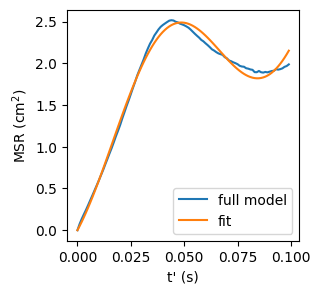

In [589]:
dict_output = comp_ols_simple(t_values,msr_values)
print_dict(dict_output)
#reasonable guess for a0
a0 = dict_output['m']/4 #- 2*D
a1 = float(a0)*4
#reasonable guess for phi_f
phase=-np.pi/2
period=100 #ms

#visualize the fitty
figsize=(3,3)
fontsize=10
fig,ax=plt.subplots(figsize=figsize)
period_of_oscillation=period*1e-3 #seconds
omega=2*np.pi/period_of_oscillation
msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
plt.plot(t_values,msr_values,label='full model')
plt.plot(t_values,msr_values_affoscillatory,label='initial guess')
# plt.plot(t_values,msr_values_affoscillatory,label='fit to full')
format_plot(ax=plt.gca(),xlabel=r"t' (s)",ylabel=r"MSR (cm$^2$)",fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

x0=a0,a1,phase
args=t_values,msr_values,D,period
square_error=comp_square_error_msr_period_fixed(x0,*args)
rmse=np.sqrt(square_error/t_values.shape[0])
print(f"baseline loss: {rmse=:.4f} cm^2 (from {a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f})")

#DONDE: vary a0, a1
# method_lst=['Nelder-Mead','Powell','CG','BFGS','Newton-CG','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr','dogleg','trust-ncg','trust-exact','trust-krylov']
#jacobian needed # 'dogleg', 'Newton-CG', 'trust-ncg', 'trust-exact','trust-krylov' #jacobian needed
method_lst=['Nelder-Mead','Powell','CG','BFGS','L-BFGS-B','TNC','COBYLA','SLSQP','trust-constr']
bounds = ((0, 100), (0, 100), (-3.2,3.2))
np.random.seed(42)   # seed to allow replication.
for method in method_lst:
    res = minimize(comp_square_error_msr_period_fixed, x0, args, method=method, bounds=bounds,tol=1e-3)
    # res.x is in the basis of a0,a1  #,period,phase
    a0_=res.x[0];a1_=res.x[1];phase_=res.x[2]
    square_error=comp_square_error_msr_period_fixed(res.x,*args)
    rmse=np.sqrt(square_error/t_values.shape[0])
    print(f"{method=}: {a0_=:.4f}, {a1_=:.4f}, {period_=:.4f}, {phase_=:.4f}, {rmse=}")

#visualize the fitty
a0_,a1_,phase_=res.x
period_=period
figsize=(3,3)
fontsize=10
fig,ax=plt.subplots(figsize=figsize)
period_of_oscillation=period_*1e-3 #seconds
omega=2*np.pi/period_of_oscillation
msr_values_affoscillatory=4*((2*D+a0_)*t_values+(a1_/omega)*(np.sin(omega*t_values+phase_)-np.sin(phase_)))
plt.plot(t_values,msr_values,label='full model')
plt.plot(t_values,msr_values_affoscillatory,label='fit')
# plt.plot(t_values,msr_values_affoscillatory,label='fit to full')
format_plot(ax=plt.gca(),xlabel=r"t' (s)",ylabel=r"MSR (cm$^2$)",fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

# (supplementary) naive guess at fit

In [ ]:
#naive guess

#INPUT: FK MODEL
boo=x_values<max_tdeath
t_values=x_values[boo].copy()*1e-3
msr_values=y_values[boo].copy() 
msr_values-= np.min(msr_values)
D=0.365 #cm^2/s, as observed
Gamma = 100. # ~ 197/2 #ms #for predicting alinear only

#INPUT: LR MODEL
boo=x_values<max_tdeath
t_values=x_values[boo].copy()*1e-3
msr_values=y_values[boo].copy()
msr_values-= np.min(msr_values)
D=0.58 #cm^2/s, as observed
Gamma = 20. # ~ 40/2 #ms #for predicting alinear only

dict_output = comp_ols_simple(t_values,msr_values)
# print_dict(dict_output)
#reasonable guess for a0
a0 = dict_output['m']/4 #- 2*D
a1 = float(a0)*4
#reasonable guess for phi_f
phase=-np.pi/2
period=80 #ms

dict_output = comp_ols_simple(t_values,msr_values)
# print_dict(dict_output)
#reasonable initial guess for a0
a0 = dict_output['m']/4 #- 2*D
a1 = float(a0)*4
#reasonable guess for phi_f
phase=-np.pi/2
period=90 #ms

#simulated annealing of all variables
x0=a0,a1,period,phase
args=t_values,msr_values,D
square_error=comp_square_error_msr(x0,*args)
rmse=np.sqrt(square_error/t_values.shape[0])
print(f"baseline loss: {rmse=:.4f} cm^2 (from {a0=:.4f}, {a1=:.4f}, {period=:.4f}, {phase=:.4f})")

#visualize the fitty
figsize=(3,3)
fontsize=10
fig,ax=plt.subplots(figsize=figsize)
period_of_oscillation=period*1e-3 #seconds
omega=2*np.pi/period_of_oscillation
msr_values_affoscillatory=4*((2*D+a0)*t_values+(a1/omega)*(np.sin(omega*t_values+phase)-np.sin(phase)))
plt.plot(t_values,msr_values,label='full model')
plt.plot(t_values,msr_values_affoscillatory,label='initial guess')
# plt.plot(t_values,msr_values_affoscillatory,label='fit to full')
format_plot(ax=plt.gca(),xlabel=r"t' (s)",ylabel=r"MSR (cm$^2$)",fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()